# First Order Time Delay Controller - Simpler Interpretation

In the Paper 'Design of Decoupled Controllers for MIMO Systems' by Aström, Johansson and Wang the Decoupling for small frequencies is described.

The following calculation is based on the First Order Time Delay (FOTD) Identification method, which results in a Two Input Two Output (TITO) System for the System in feedforward representation. 

To Decouple the system a Taylor Series around the steady state s=0 is used to derive Interaction from an input to another output. Since we approximate the system always with a FOTD Model, we can derive the interaction:

In [1]:
# Import the needed packages, SymPy
import sympy as sp
from sympy import init_printing
init_printing()

In [2]:
# Define the variables
# Complex variable
s = sp.symbols('s')
# FOTD Coeffficients
T1,T2,T3,T4 = sp.symbols('T_11 T_12 T_21 T_22')
K1,K2,K3,K4 = sp.symbols('K_11 K_12 K_21 K_22')
# Time Delay Coefficients
L1,L2,L3,L4 = sp.symbols('L_11 L_12 L_21 L_22')
# Controller variables for the diagonal controller for Q
C1D, C2D = sp.symbols('C_11^* C_22^*')
# Controller variables for the diagonal controller for G
C1, C2 = sp.symbols('C_11 C_22')
# Proportional Gain
kp1,kp2= sp.symbols('k_P1 k_P2')
# Integral Gain
ki1,ki2 = sp.symbols('k_I1 k_I2')

# Vectorize
TV = [T1,T2,T3,T4]
KV = [K1,K2,K3,K4]
LV = [L1,L2,L3,L4]
QV = [[C1D,0],[0,C2D]]
GV = [[C1,0],[0,C2]]
PV = [[kp1,0],[0,kp2]]
IV = [[ki1,0],[0,ki2]]


# Define a FOTD
def FOTD(K,T,L):
    return K/(T*s+1) * sp.exp(-L*s)

#Define a Matrix of FOTD with diagonal and antidiagonal part
G = sp.zeros(2)
for i in range(0,4):
    G[i]= FOTD(KV[i],TV[i],LV[i])
    
GD = sp.Matrix([[G[0],0],[0,G[3]]])
GA = sp.Matrix([[0,G[1]],[G[2],0]])
    
#Define the diagonal controller in Q
KQ = sp.Matrix(QV)

#Define the diagonal controller in G
KG = sp.Matrix(GV)

# Define the Proportional and Integral Controller for later use
KP = sp.Matrix(PV)
KI = sp.Matrix(IV)
PI = KP+KI*(1/s)
# Define the decoupler with diagonal and antidiagonal part
D = G.subs(s,0)
D = sp.simplify(D**-1)
DD = sp.Matrix([[D[0],0],[0,D[3]]])
DA = sp.Matrix([[0,D[1]],[D[2],0]])

## Design the Splitter

The splitter is an equivalent interpretation of the decoupler but holds a much more intuitive interpretation of the problem of decoupling with regards to the diagonal controller designed from the transfer function matrix.

It is given as
$S = D D_D^{-1}$

In [3]:
# Define the splitter for static decoupling
SS = D*DD.inv()

## Get the Interaction
Since we want to detune with respect to the interaction of the antidiagonal parts, we can directly identify the first coefficients of the Taylor Series

$\Gamma_A = \frac{d}{ds} \left[G_D D_A D_D^{-1} + G_A\right]$

And Solve for the interaction

$K_I \leq \frac{1}{\sigma} \Gamma_A^{-1} H_{A,Max}$

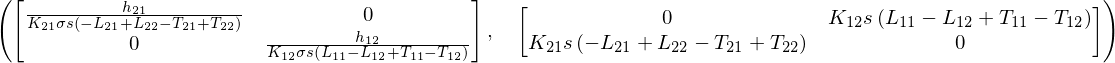

In [4]:
# Get the Gamma Matrix with the assumption of 
Gamma = sp.simplify(sp.diff(GD*DA*DD.inv()+GA,s).subs(s,0))*s
# Get the Equations for H
h12, h21 = sp.symbols('h_12 h_21')
# Get the safety factor ( interpreted as maximum sensitivity)
sigma = sp.symbols('\sigma')
HMax = sp.Matrix([[0,h12],[h21,0]])
1/sigma*Gamma.inv()*HMax,Gamma

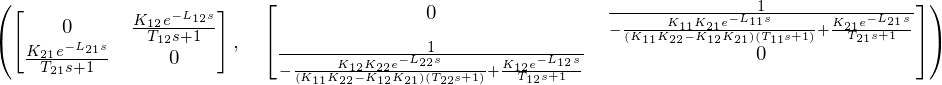

In [9]:
GA, (GA+DA*GD).inv()

### Design a Dynamic Decoupler


In [12]:
# Approximate FOTD with Taylor series
def AFOTD(K,T,L):
    return K/(T*s+1) * (1-s*L)

#Define a Matrix of FOTD with diagonal and antidiagonal part
G = sp.zeros(2)
for i in range(0,4):
    G[i]= AFOTD(KV[i],TV[i],LV[i])
    
GD = sp.Matrix([[G[0],0],[0,G[3]]])
GA = sp.Matrix([[0,G[1]],[G[2],0]])

# Define a decoupler
D = sp.simplify(G.inv())
DD = sp.Matrix([[D[0],0],[0,D[3]]])
DA = sp.Matrix([[0,D[1]],[D[2],0]])

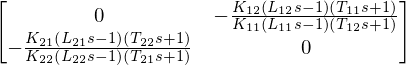

In [14]:
# Design the splitter
S = D*DD.inv() - sp.eye(2)
S

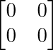

In [15]:
# Get the Gamma Matrix as proof for decoupling
Gamma = sp.simplify(sp.diff(GD*DA*DD.inv()+GA,s).subs(s,0))
Gamma